## Enunciado

>Considere el proyecto cuya información se adjunta.
> 1. Dibuje el diagrama Pert y determine el camino crítico.
> 2. Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.

In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 22.20 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, b, m, a, coste_duracion_pert, coste_duracion_tope, duracion_tope
     ('A', '---  ',   6,  2.5, 2, 1600, 1800, 2),
     ('B', '---  ',   6,    6, 6, 2800, 2820, 1),
     ('C', '---  ',   1,    1, 1,  600,  600, 1),
     ('D', '---  ',   3,    3, 3,  600,  607, 2),
     ('E', 'A,B  ',  12,    5, 4, 1600, 2200, 2),
     ('F', 'A,B  ',  12,  2.5, 2, 2000, 2200, 1),
     ('G', 'B,C,P',   6, 1.25, 1,  600,  700, 1),
     ('H', 'B,C,P ',  20,   15, 10, 3500, 3620, 3),
     ('I', 'D    ',  28,   18, 8, 3500, 3503, 17),
     ('J', 'E,M  ',   4,    4, 4, 1500, 1500, 2),
     ('K', 'F    ',   7,    7, 7, 2000, 2000, 3),
     ('L', 'J,K,G',   1,    1, 1, 1000, 1000, 1),
     ('M', 'F    ',   3,    3, 3,  500,  500, 1),
     ('N', 'J,K,G',   1,    1, 1, 1000, 1000, 1),
     ('P', 'D    ',   3,    3, 3, 1000, 1150, 1),

] ,columns=['actividad', 'precedentes', 'b', 'm', 'a',
            'coste_duracion_pert', 'coste_duracion_tope', 'duracion_tope']).set_index('actividad')

datos_enunciado

,precedentes,b,m,a,coste_duracion_pert,coste_duracion_tope,duracion_tope
actividad,,,,,,,
A,---,6,2.50,2,1600,1800,2
B,---,6,6.00,6,2800,2820,1
C,---,1,1.00,1,600,600,1
D,---,3,3.00,3,600,607,2
E,"A,B",12,5.00,4,1600,2200,2
F,"A,B",12,2.50,2,2000,2200,1
G,"B,C,P",6,1.25,1,600,700,1
H,"B,C,P",20,15.00,10,3500,3620,3
I,D,28,18.00,8,3500,3503,17


## Solución
### Apartado 1

> Dibuje el diagrama Pert y determine el camino crítico.

En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [3]:
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='actividad', predecessor='precedentes')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,P
activities,,,,,,,,,,,,,,,
A,,,,,,,,,,,,,,,
B,,,,,,,,,,,,,,,
C,,,,,,,,,,,,,,,
D,,,,,,,,,,,,,,,
E,True,True,,,,,,,,,,,,,
F,True,True,,,,,,,,,,,,,
G,,True,True,,,,,,,,,,,,True
H,,True,True,,,,,,,,,,,,True
I,,,,True,,,,,,,,,,,


##### Precálculo de variables de interés

A partir de los datos del enunciado podemos calcular la duración media, y el coste unitario de reducción que utilizaremos para contestar las preguntas realizadas.

In [4]:
datos_proyecto['duracion'] = datos_proyecto.eval('(b + 4*m +a)/6')
datos_proyecto['cur'] = datos_proyecto.eval('(coste_duracion_tope - coste_duracion_pert)/(duracion - duracion_tope)')
datos_proyecto[['b', 'm', 'a', 'duracion', 'cur']]

,b,m,a,duracion,cur
actividad,,,,,
A,6,2.50,2,3.0,200.000000
B,6,6.00,6,6.0,4.000000
C,1,1.00,1,1.0,NaN
D,3,3.00,3,3.0,7.000000
E,12,5.00,4,6.0,150.000000
F,12,2.50,2,4.0,66.666667
G,6,1.25,1,2.0,100.000000
H,20,15.00,10,15.0,10.000000
I,28,18.00,8,18.0,3.000000


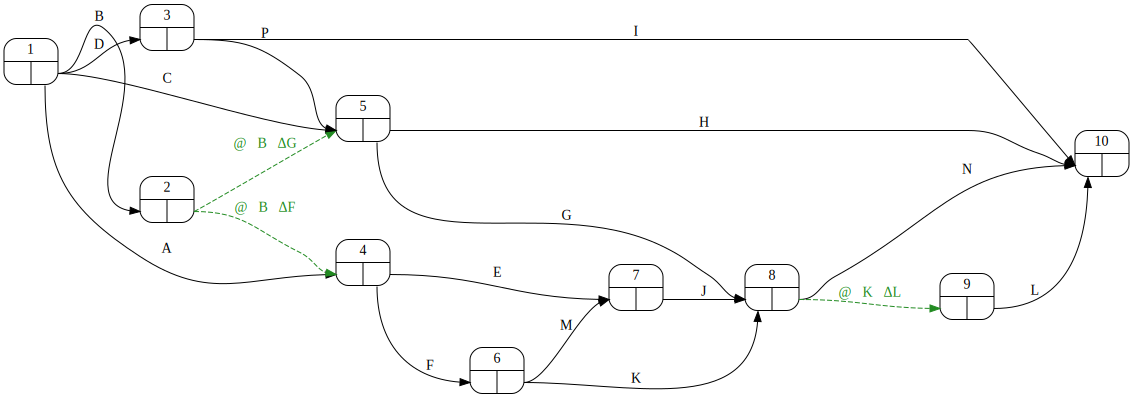

In [5]:
proyecto = prelaciones.create_project()
proyecto.pert(ranksep=1)

##### Grafo PERT con numeración de nodos

##### Matriz de Zaderenko

In [6]:
proyecto.zaderenko(datos_proyecto['duracion'])

,1,2,3,4,5,6,7,8,9,10,early
1,,6.0,3.0,3.0,1.0,,,,,,0.0
2,,,,0.0,0.0,,,,,,6.0
3,,,,,3.0,,,,,18.0,3.0
4,,,,,,4.0,6.0,,,,6.0
5,,,,,,,,2.0,,15.0,6.0
6,,,,,,,3.0,7.0,,,10.0
7,,,,,,,,4.0,,,13.0
8,,,,,,,,,0.0,1.0,17.0
9,,,,,,,,,,1.0,17.0
10,,,,,,,,,,,21.0


In [7]:
resultados_pert = proyecto.calculate_pert(datos_proyecto['duracion'])
resultados_pert['nodes']

,early,late
1,0,0
2,6,6
3,3,3
4,6,9
5,6,6
6,10,13
7,13,16
8,17,20
9,17,20
10,21,21


##### Holguras

In [8]:
resultados_pert['activities']

,H_total
@∇B⤑ΔF,3
@∇B⤑ΔG,0
@∇K⤑ΔL,3
A,6
B,0
C,5
D,0
E,4
F,3
G,12


###### Camino crítico

In [9]:
camino_critico = proyecto.critical_path(datos_proyecto['duracion'])
camino_critico

{'Route_1': ['B', '@∇B⤑ΔG', 'H'],
 'Route_10': ['D', 'I'],
 'Route_11': ['D', 'P', 'H']}

##### Grafo PERT con indicación de tiempos

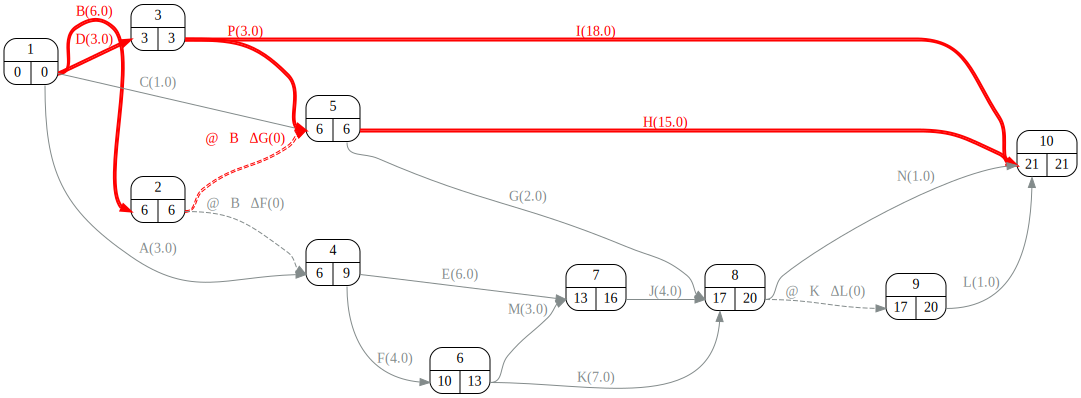

In [10]:
proyecto.pert(durations=datos_proyecto['duracion'])

### Apartado 2.

> Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.


In [11]:
ackoff, best_option, duration, available = proyecto.ackoff( durations=datos_proyecto['duracion'],
                                                            min_durations=datos_proyecto['duracion_tope'],
                                                            costs=datos_proyecto['cur'],
                                                            reduction=2)
ackoff

D shape (15,)
Path matrix shape (22, 15)


Step: 0,	 Best option: ['B', 'D'], 	 Cost: 11.0, 	 Critical paths: ['Route_1', 'Route_10', 'Route_11']
Step: 1,	 Best option: ['H', 'I'], 	 Cost: 13.0, 	 Critical paths: ['Route_1', 'Route_10', 'Route_11']





,A,B,C,D,E,F,G,H,I,J,K,L,M,N,P,0,1,2
Route_1,,4.0,,,,,,10.0,,,,,,,,21.0,20.0,19.0
Route_2,,4.0,,,,,100.0,,,,,,,,,9.0,8.0,8.0
Route_3,,4.0,,,,,100.0,,,,,,,,,9.0,8.0,8.0
Route_4,,4.0,,,150.0,,,,,0.0,,,,,,17.0,16.0,16.0
Route_5,,4.0,,,150.0,,,,,0.0,,,,,,17.0,16.0,16.0
Route_6,,4.0,,,,66.7,,,,,0.0,,,,,18.0,17.0,17.0
Route_7,,4.0,,,,66.7,,,,,0.0,,,,,18.0,17.0,17.0
Route_8,,4.0,,,,66.7,,,,0.0,,,0.0,,,18.0,17.0,17.0
Route_9,,4.0,,,,66.7,,,,0.0,,,0.0,,,18.0,17.0,17.0
Route_10,,,,7.0,,,,,3.0,,,,,,,21.0,20.0,19.0


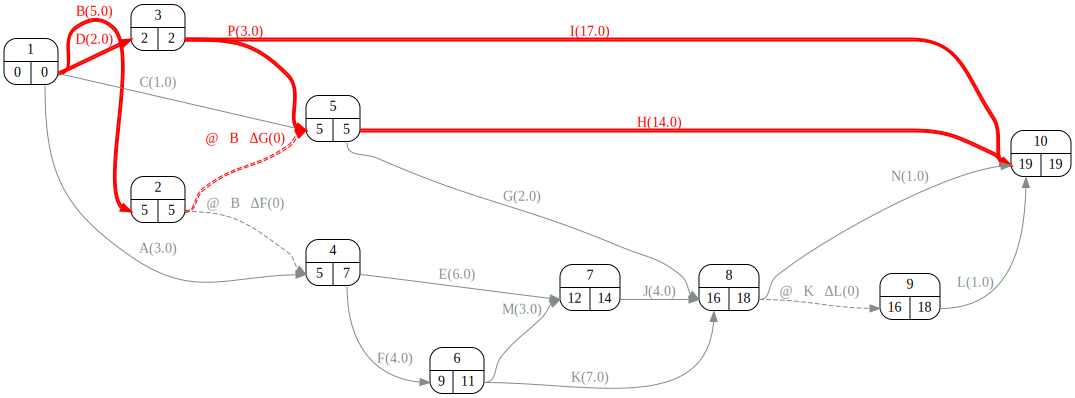

In [12]:
proyecto.pert(durations=duration)